In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Dropout, InputLayer
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, RandomRotation, RandomTranslation

import os

Reading in the .csv with image file, hotel chain, hotel id, and timestamp

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df.head()

,image,chain,hotel_id,timestamp
0,8000d59f6a3d765f.jpg,85,24607,2018-11-28 05:42:31
1,8000febe81817f7f.jpg,6,25389,2017-01-01 07:01:46
2,80053befc2d42fba.jpg,3,672,2018-01-26 13:22:07
3,8007fa0a8fe89f9d.jpg,5,63866,2020-07-03 02:31:31
4,800a4a6b6f6d2df6.jpg,0,12036,2017-09-22 17:59:22


Prepending the relative filepath to each filename

In [4]:
df.image = './train_images/' + df.chain.astype(str) + '/' + df.image

Paring the dataframe down to only chain 0 (hotels which don't belong to a chain, or who's chain is unknown)

In [5]:
df = df[df.chain == 0]

Dropping unnecessary columns (keeping just filepath and hotel id [the target])

In [6]:
df.drop(columns=['chain', 'timestamp'], inplace=True)

In [7]:
df.head()

,image,hotel_id
4,./train_images/0/800a4a6b6f6d2df6.jpg,12036
14,./train_images/0/8026797d7b65c4b2.jpg,36739
15,./train_images/0/80286fe316ff68a5.jpg,13494
16,./train_images/0/8028cf47a37b369d.jpg,35733
25,./train_images/0/802af4d04faf14df.jpg,3876


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20259 entries, 4 to 97550
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     20259 non-null  object
 1   hotel_id  20259 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 474.8+ KB


In [9]:
df.hotel_id = df.hotel_id.astype(str)

Using Keras's ImageDataGenerator to read in images in batches, rescaling as well as applying some data augmentation to help with generalizing to new data, and finally splitting the dataset into train and validation subsets.

In [61]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25, rotation_range=90, 
                           width_shift_range=.25, height_shift_range=.25, horizontal_flip=True,
                          vertical_flip=True, channel_shift_range=.25)

In [103]:
train_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=None,
x_col="image",
y_col="hotel_id",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(50,50))

valid_generator=datagen.flow_from_dataframe(
dataframe=df,
directory=None,
x_col="image",
y_col="hotel_id",
subset="validation",
batch_size=1,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(50,50))

C:\Users\c24th\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 15194 validated image filenames belonging to 1749 classes.
Found 5064 validated image filenames belonging to 1749 classes.


C:\Users\c24th\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:283: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


This reduced the number of observations I was training on from ~97,000 to ~20,000, with a 75/25 train/test split, as well as reducing total observed classes from 7,770 to 1,749

Assembling the CNN model:

This is the result of a great deal of tweaking and iterating, but I eventually settled on the following architecture:
- Three sets of convolutional and pooling layers with padding
    - 32 filters in the first conv layer, with 16 in the second and third
    - Each layer used ReLU activation
- A flatten layer
- 2 dense layers of 1,000 nodes each (ReLU activation)
- And a final output layer of 1,749 nodes (one per class) with a softmax activation

In [63]:
model = Sequential()

In [64]:
model.add(InputLayer(input_shape=(50,50,3)))

# model.add(RandomFlip())
# model.add(RandomZoom(0.1, .1))
# model.add(RandomRotation(0.1))
# model.add(RandomTranslation(.1, .1))

model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3, padding='valid'))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3, padding='valid'))
model.add(Conv2D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(3, padding='valid'))


model.add(Flatten())

# model.add(Dense(4096, activation='relu'))
# model.add(Dense(4096, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1749, activation='softmax'))

Model was compiled with the Adam optimizer, with categorical cross-entropy as the loss function, and tracking accuracy and precision as scoring metrics

In [65]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])

In [66]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 16)          2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 16)               

Due to the computational load of processing so many images, I not only had to read in the images in batches, but I also had to fit the model iteratively. As a result, I ran the `.fit()` cell below iteratively instead of repeating the cell over and over. This model ran three times: first and second at 20 epochs, then overnight for 50. I would caution against rerunning this cell without adjusting the number of epochs, as this will likely brick your computer for the duration.

In [166]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history3 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

C:\Users\c24th\anaconda3\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DEPRECATED:


Epoch 1/50
474/474 [==============================] - 549s 1s/step - loss: 5.9273 - acc: 0.0285 - precision: 0.6000 - val_loss: 8.1365 - val_acc: 0.0170 - val_precision: 0.6667
Epoch 2/50
474/474 [==============================] - 553s 1s/step - loss: 5.9221 - acc: 0.0297 - precision: 0.6316 - val_loss: 8.1057 - val_acc: 0.0188 - val_precision: 0.1429
Epoch 3/50
474/474 [==============================] - 553s 1s/step - loss: 5.8936 - acc: 0.0305 - precision: 0.5385 - val_loss: 8.1037 - val_acc: 0.0192 - val_precision: 0.1667
Epoch 4/50
474/474 [==============================] - 551s 1s/step - loss: 5.8714 - acc: 0.0302 - precision: 0.6667 - val_loss: 8.2688 - val_acc: 0.0180 - val_precision: 0.1667
Epoch 5/50
474/474 [==============================] - 555s 1s/step - loss: 5.8567 - acc: 0.0317 - precision: 0.6364 - val_loss: 8.1533 - val_acc: 0.0148 - val_precision: 0.3333
Epoch 6/50
474/474 [==============================] - 551s 1s/step - loss: 5.8447 - acc: 0.0288 - precision: 0.5357

474/474 [==============================] - 549s 1s/step - loss: 5.3633 - acc: 0.0481 - precision: 0.6038 - val_loss: 9.4993 - val_acc: 0.0194 - val_precision: 0.2143
Epoch 48/50
474/474 [==============================] - 546s 1s/step - loss: 5.3406 - acc: 0.0502 - precision: 0.6393 - val_loss: 9.6452 - val_acc: 0.0180 - val_precision: 0.4615
Epoch 49/50
474/474 [==============================] - 552s 1s/step - loss: 5.3468 - acc: 0.0479 - precision: 0.5333 - val_loss: 9.6644 - val_acc: 0.0180 - val_precision: 0.3571
Epoch 50/50
474/474 [==============================] - 547s 1s/step - loss: 5.3462 - acc: 0.0512 - precision: 0.6122 - val_loss: 9.6359 - val_acc: 0.0158 - val_precision: 0.4444


The following graphs show train and validation loss, accuracy, and precision (respectively) over each iteration of the dataset. 

The first iteration looked promising; train/test loss was decreasing, accuracy was increasing.

The second iteration was somewhat disheartening; train loss kept decreasing, but test loss diverged and began increasing. I hadn't lost hope, however, as the test accuracy seemed to still be improving.

The third, long iteration was the nail in the coffin; train and test loss continued to diverge, but now the accuracy was diverging as well. Train accuracy continued to climb, as one would expect, but test accuracy steadily hovered around 1-2%.

Precision on the first iteration stayed at exactly 0, but on the last two iterations was all over the place.

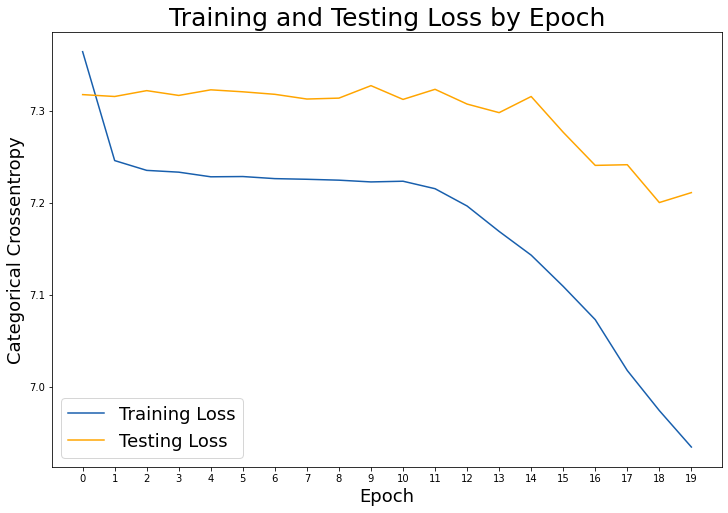

In [179]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

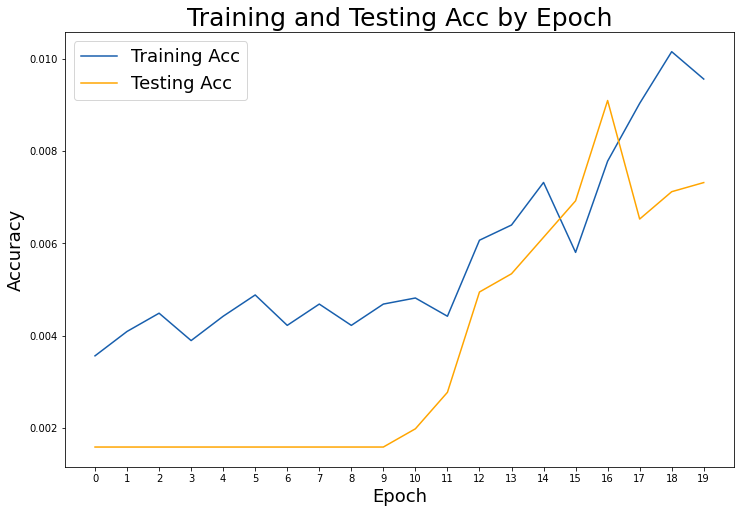

In [180]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['acc']
test_loss = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Acc', color='#185fad')
plt.plot(test_loss, label='Testing Acc', color='orange')

# Set title
plt.title('Training and Testing Acc by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

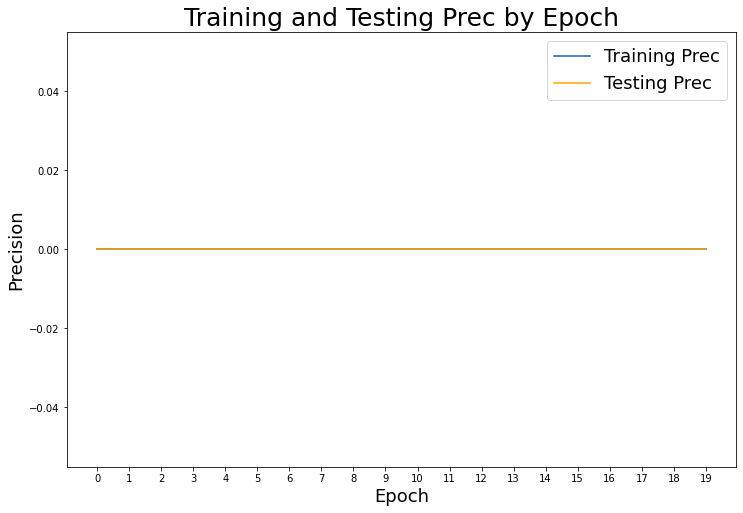

In [181]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['precision']
test_loss = history.history['val_precision']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Prec', color='#185fad')
plt.plot(test_loss, label='Testing Prec', color='orange')

# Set title
plt.title('Training and Testing Prec by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

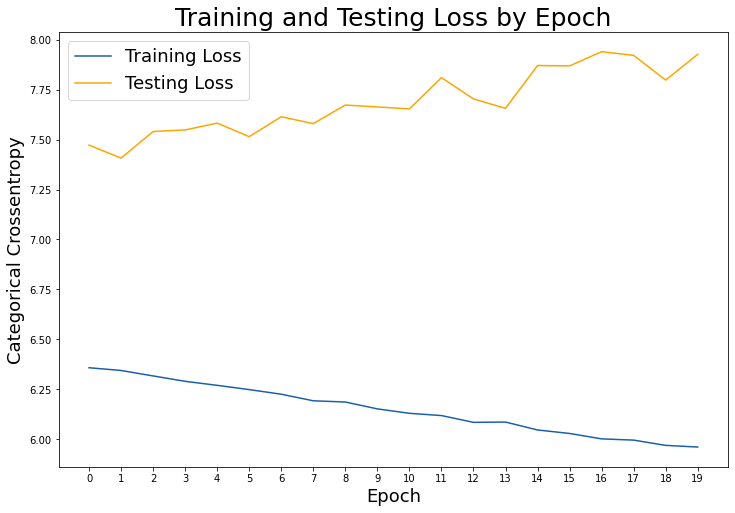

In [182]:
# Check out our train loss and test loss over epochs.
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

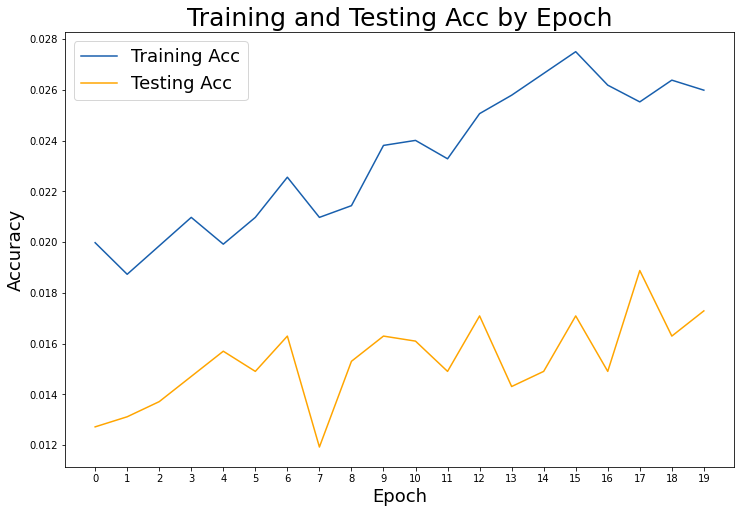

In [183]:
# Check out our train loss and test loss over epochs.
train_loss = history2.history['acc']
test_loss = history2.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Acc', color='#185fad')
plt.plot(test_loss, label='Testing Acc', color='orange')

# Set title
plt.title('Training and Testing Acc by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

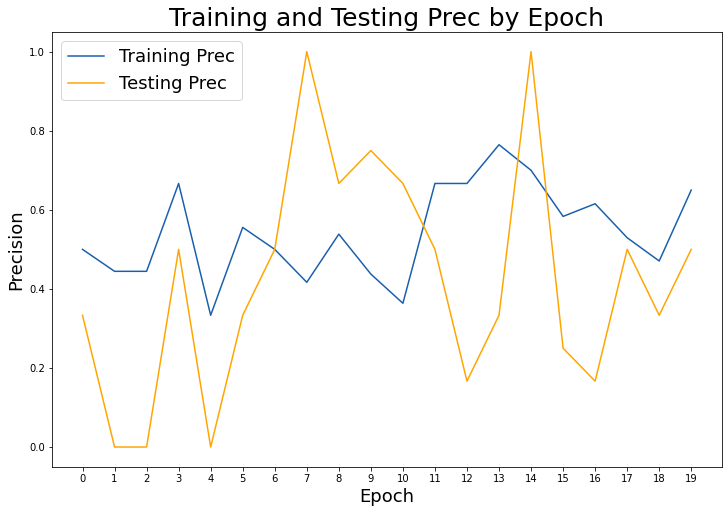

In [184]:
# Check out our train loss and test loss over epochs.
train_loss = history2.history['precision']
test_loss = history2.history['val_precision']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Prec', color='#185fad')
plt.plot(test_loss, label='Testing Prec', color='orange')

# Set title
plt.title('Training and Testing Prec by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.xticks(np.arange(20), np.arange(20))

plt.legend(fontsize = 18);

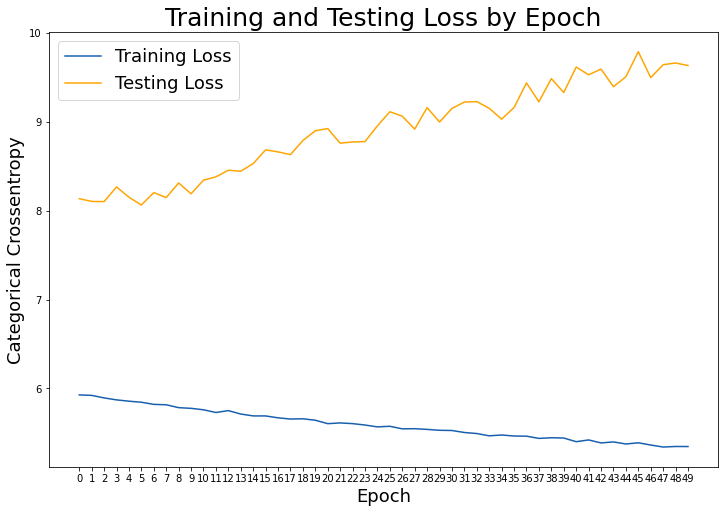

In [185]:
# Check out our train loss and test loss over epochs.
train_loss = history3.history['loss']
test_loss = history3.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(50), np.arange(50))

plt.legend(fontsize = 18);

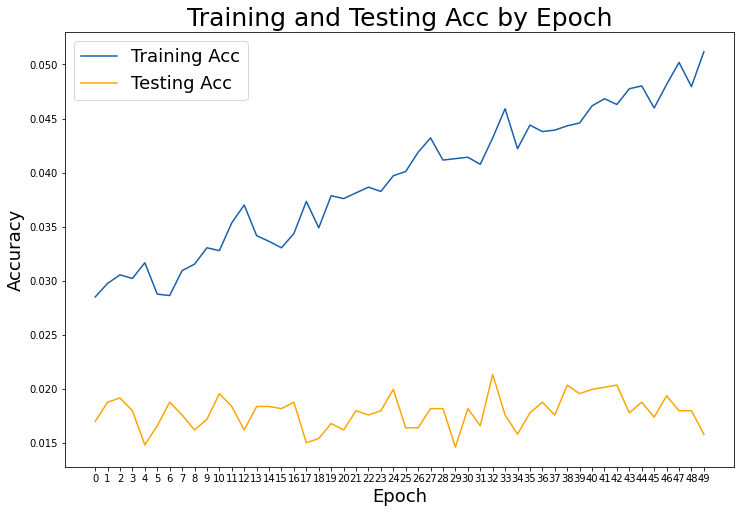

In [186]:
# Check out our train loss and test loss over epochs.
train_loss = history3.history['acc']
test_loss = history3.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Acc', color='#185fad')
plt.plot(test_loss, label='Testing Acc', color='orange')

# Set title
plt.title('Training and Testing Acc by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(np.arange(50), np.arange(50))

plt.legend(fontsize = 18);

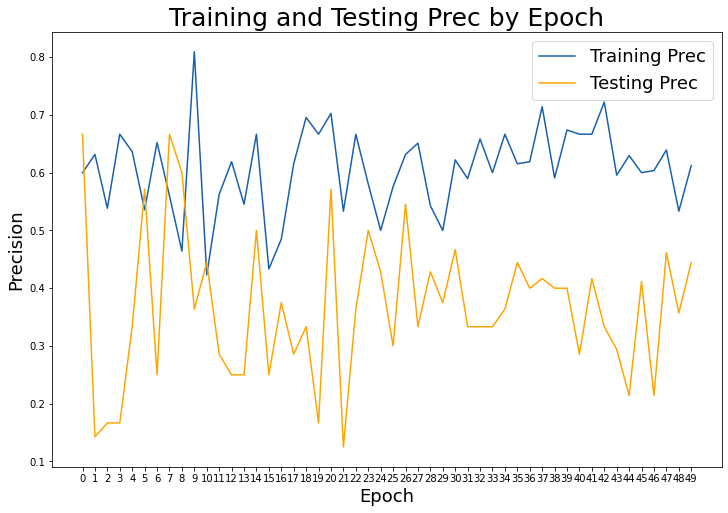

In [187]:
# Check out our train loss and test loss over epochs.
train_loss = history3.history['precision']
test_loss = history3.history['val_precision']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Prec', color='#185fad')
plt.plot(test_loss, label='Testing Prec', color='orange')

# Set title
plt.title('Training and Testing Prec by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Precision', fontsize = 18)
plt.xticks(np.arange(50), np.arange(50))

plt.legend(fontsize = 18);

In [170]:
model.save('./models/take_6')

INFO:tensorflow:Assets written to: ./models/take_6\assets


The highest accuracy reached on the validation data was roughly 2%

In [173]:
max(history3.history['val_acc'])

0.02132701501250267

The next few cells entail predicting on the validation set and then some exploratory analysis of the results (which were underwhelming, to say the least)

In [118]:
hats = model.predict_generator(valid_generator, verbose=1, steps=5064)

   8/5064 [..............................] - ETA: 41s 

C:\Users\c24th\anaconda3\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  DEPRECATED:


5064/5064 [==============================] - 142s 28ms/step


In [120]:
df2 = pd.DataFrame(hats[:3], index=valid_generator.classes[:3])

In [121]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748
60,0.000326,0.000359,0.003606,0.001199,0.000519,0.000064,1.781309e-07,0.000163,0.000002,0.000036,...,0.000005,5.514012e-04,0.000020,0.000655,0.000007,0.000178,0.000028,0.000086,0.001264,0.000008
784,0.000068,0.000019,0.000634,0.000834,0.000062,0.000307,1.643574e-04,0.000263,0.001222,0.001741,...,0.001898,3.205653e-07,0.000050,0.003835,0.001911,0.002757,0.000766,0.000478,0.000742,0.000893
110,0.000962,0.000880,0.000050,0.000071,0.002304,0.003323,9.332866e-05,0.000971,0.000069,0.000266,...,0.000679,3.147067e-04,0.000569,0.000037,0.000008,0.000006,0.000913,0.001154,0.000806,0.000130


In [129]:
df2 = df2.T

In [130]:
df2

,60,784,110
0,0.000326,0.000068,0.000962
1,0.000359,0.000019,0.000880
2,0.003606,0.000634,0.000050
3,0.001199,0.000834,0.000071
4,0.000519,0.000062,0.002304
...,...,...,...
1744,0.000178,0.002757,0.000006
1745,0.000028,0.000766,0.000913
1746,0.000086,0.000478,0.001154
1747,0.001264,0.000742,0.000806


In [132]:
df2.columns = ['60', '784', '110']

In [143]:
a = df2['60'].sort_values(ascending=False).head()

In [144]:
a[60] = df2['60'][60]

In [145]:
a

735     0.028752
537     0.017652
695     0.016373
757     0.015934
1277    0.014975
60      0.000029
Name: 60, dtype: float64

In [140]:
df2['60'][60]

2.907219e-05

In [146]:
b = df2['784'].sort_values(ascending=False).head()

In [147]:
b[784] = df2['784'][784]

In [148]:
c = df2['110'].sort_values(ascending=False).head()

In [149]:
c[110] = df2['110'][110]

In [150]:
a, b, c

(735     0.028752
 537     0.017652
 695     0.016373
 757     0.015934
 1277    0.014975
 60      0.000029
 Name: 60, dtype: float64,
 564     0.011694
 1226    0.007703
 1403    0.006552
 719     0.006265
 906     0.005417
 784     0.000273
 Name: 784, dtype: float64,
 233     0.011652
 1409    0.008451
 742     0.007622
 537     0.006869
 410     0.006506
 110     0.001044
 Name: 110, dtype: float64)

In [174]:
pd.DataFrame(valid_generator.classes).value_counts(normalize=True)

1364    0.004937
1058    0.004739
249     0.004542
1692    0.004344
215     0.004344
          ...   
1318    0.000197
672     0.000197
673     0.000197
678     0.000197
0       0.000197
Length: 1552, dtype: float64

Below are predictions on the first three images in the validation set. The tables show the top 5 predicted classes for each image, with the sixth value being the model's confidence in the true class label. As you can see, this model performs quite poorly

 |Class Prediction (60)|Confidence|
 |-|-|
 |735    |0.028752|
 |537     |0.017652|
 |695     |0.016373|
 |757     |0.015934|
 |1277    |0.014975|
 |60      |0.000029|
 
 |Class Prediction (784)|Confidence|
 |-|-|
 |564     |0.011694|
 |1226    |0.007703|
 |1403    |0.006552|
 |719     |0.006265|
 |906     |0.005417|
 |784     |0.000273|
 
 |Class Prediction (110)|Confidence|
 |-|-|
 |233     |0.011652|
 |1409    |0.008451|
 |742     |0.007622|
 |537     |0.006869|
 |410     |0.006506|
 |110     |0.001044|
